In [1]:
import os
import re
import shutil
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape, Input

In [2]:
# Download MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocessing
X = np.concatenate((x_train, x_test), axis=0)
np.random.seed(42)
np.random.shuffle(X)
X = X.astype("float32") / 255.
X = X.reshape(X.shape + (1,))
print(f"The shape of dataset: {X.shape}")

The shape of dataset: (70000, 28, 28, 1)


In [3]:
# Use modified grid_plot functions in the tutorial           
def grid_plot(images, epoch="", name="", n=3, save=False, scale=False):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    if save:
        filename = 'results/generated_plot_e%03d_f.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()
    plt.show()

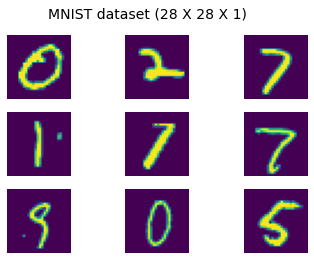

In [4]:
np.random.seed(42)
grid_plot(X[np.random.randint(0, 1000, 9)], name="MNIST dataset (28 X 28 X 1)", n=3)

In [5]:
# Use modified build_conv_net and build_deconv_net functions in the tutorial
def build_conv_net(in_shape, out_shape, out_activation='sigmoid'):
    """
    Build a basic convolutional network
    """
    in_put = Input(shape=in_shape)
    
    x = Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(in_put)
    x = Conv2D(kernel_size=3, filters=64, padding='same', activation='relu', strides=(2,2))(x)
    x = Conv2D(kernel_size=3, filters=64, padding='same', activation='relu')(x)
    x = Conv2D(kernel_size=3, filters=64, padding='same', activation='relu')(x)
    
    x = Flatten()(x)
    x = Dense(out_shape, activation=out_activation)(x)
    model = tf.keras.Model(in_put, x)
    model.summary()
    return model


def build_deconv_net(latent_dim, activation_out='sigmoid'):
    """
    Build a deconvolutional network for decoding/upscaling latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that 
    were used in the downsampling network and the Conv2DTranspose layers are used instead of Conv2D layers. 
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    shape of our input images. 
    """
    in_put = Input(shape=latent_dim)
    x = Dense(14 * 14 * 64)(in_put)
    x = Reshape((14, 14, 64))(x) # This matches the output size of the downsampling architecture
    x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2,2))(x)
    x = Conv2D(filters=1, kernel_size=3, activation=activation_out, padding='same')(x)
    model = tf.keras.Model(in_put, x)
    model.summary()
    return model

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dense_6 (Dense)             (None, 32)                4014

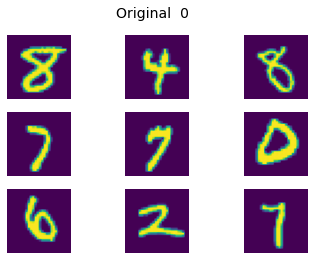

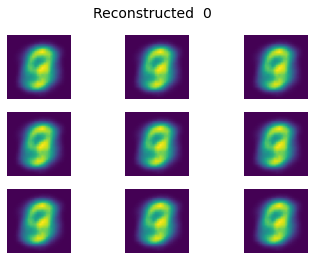


Epoch:  1


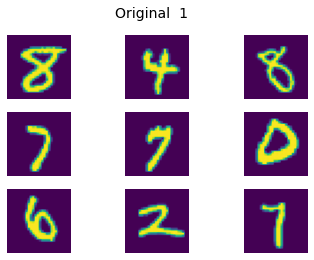

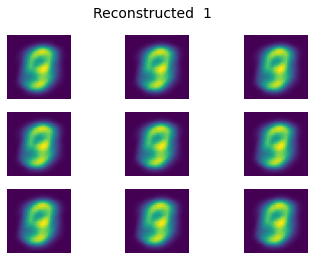


Epoch:  2


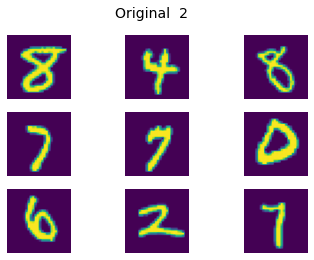

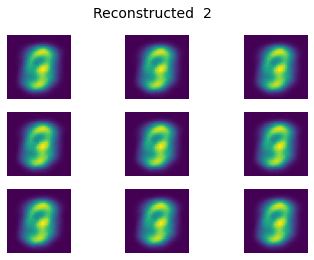


Epoch:  3


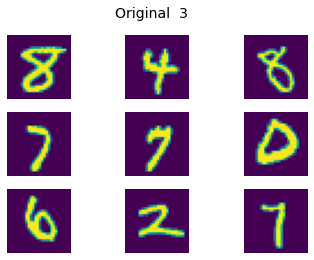

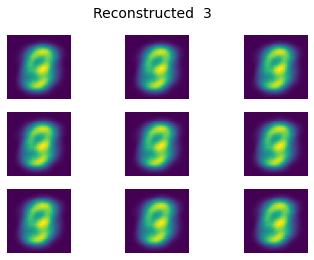


Epoch:  4


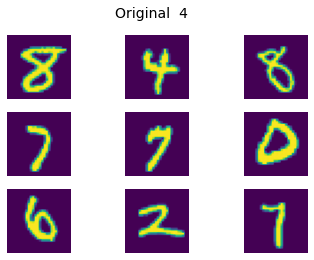

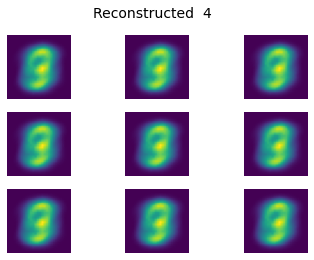


Epoch:  5


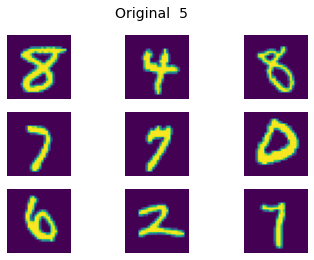

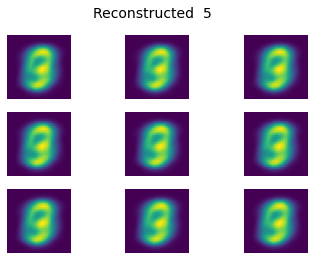


Epoch:  6


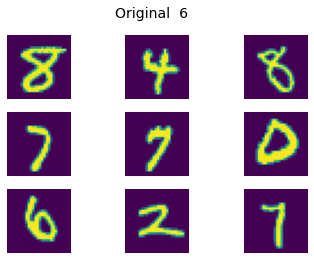

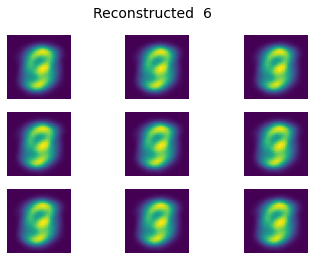


Epoch:  7


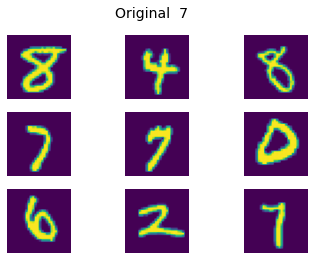

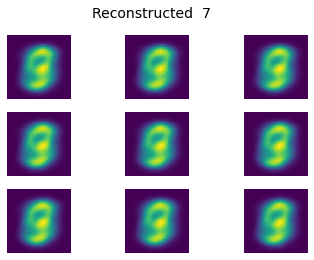


Epoch:  8


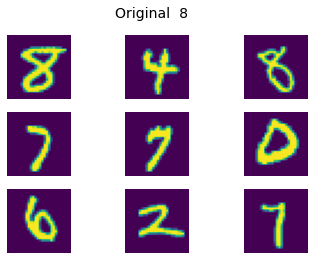

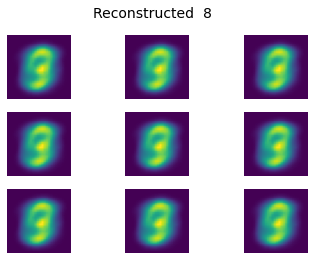


Epoch:  9


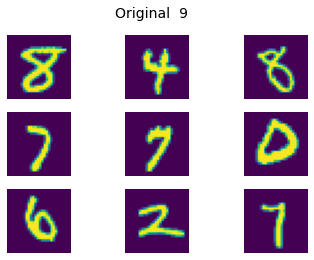

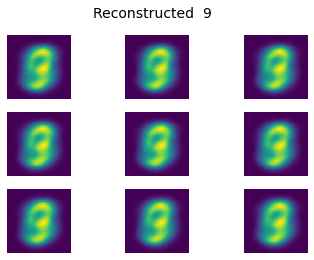


Epoch:  10


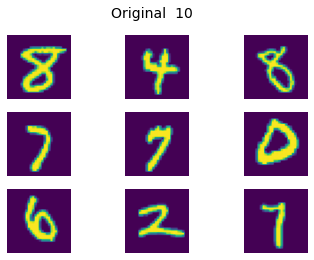

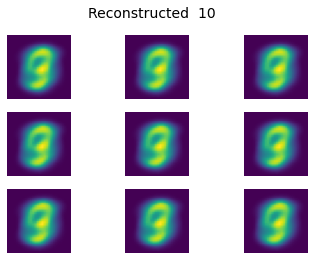

In [19]:
# CAE
# Use the build_convolutional_autoencoder function in the tutorial
def build_convolutional_autoencoder(data_shape, latent_dim):
    encoder = build_conv_net(in_shape=data_shape, out_shape=latent_dim)
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid')
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
    return autoencoder

# Defining the model dimensions and building it
image_size = X.shape[1:]
latent_dim = 32
num_filters = 64
cae = build_convolutional_autoencoder(image_size, latent_dim)

for epoch in range(0, 11):
    cae.fit(x=X, y=X, epochs=1, batch_size=64, verbose=0)
    print('\nEpoch: ', epoch)
    samples = X[:9]
    reconstructed = cae.predict(samples, verbose=0)
    grid_plot(samples, epoch, name='Original', n=3, save=False)
    grid_plot(reconstructed, epoch, name='Reconstructed', n=3, save=False)

In [7]:
# Use the Sampling class and the build_vae function in the tutorial
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

    
def build_vae(data_shape, latent_dim, filters=128):

    # Building the encoder - starts with a simple downsampling convolutional network  
    encoder = build_conv_net(data_shape, latent_dim*2)
    
    # Adding special sampling layer that uses the reparametrization trick 
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])
    
    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid')
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))
    
    # Adding the special loss term
    kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
    vae.add_loss(kl_loss/tf.cast(tf.keras.backend.prod(data_shape), tf.float32))

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')

    return encoder, decoder, vae

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                8028

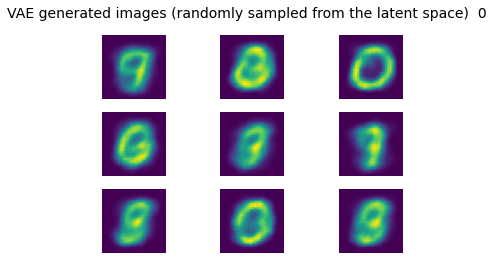

4375/4375 [==============================] - 36s 8ms/step - loss: 0.2585


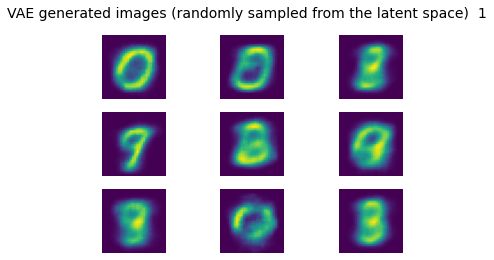

4375/4375 [==============================] - 35s 8ms/step - loss: 0.2569


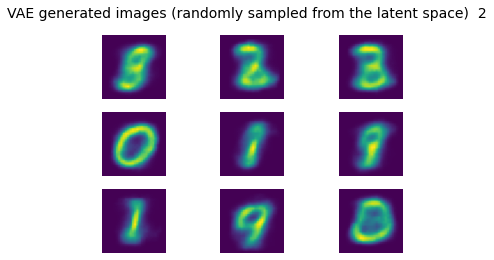

4375/4375 [==============================] - 36s 8ms/step - loss: 0.2560


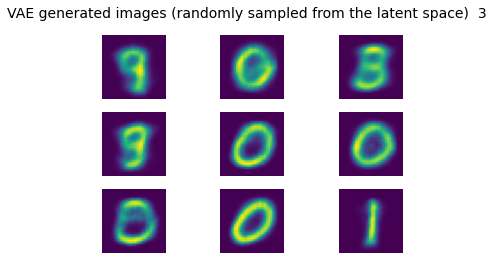

4375/4375 [==============================] - 36s 8ms/step - loss: 0.2555


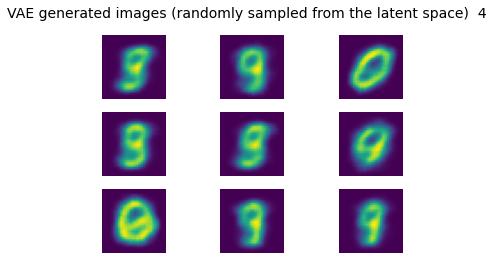

4375/4375 [==============================] - 36s 8ms/step - loss: 0.2552


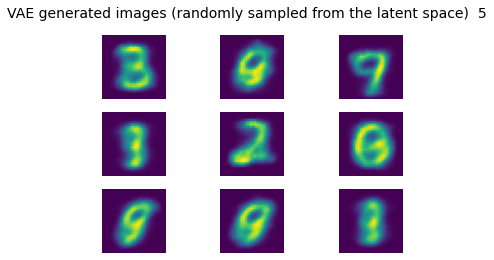

4375/4375 [==============================] - 36s 8ms/step - loss: 0.2554


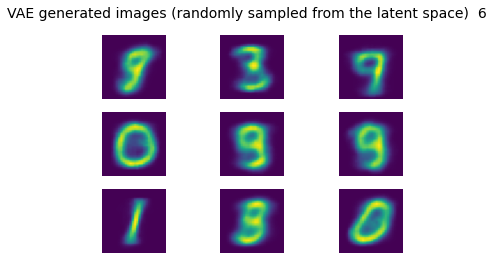

4375/4375 [==============================] - 36s 8ms/step - loss: 0.2550


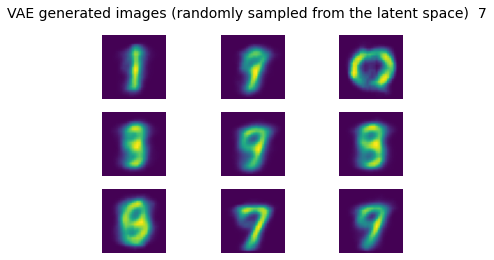

4375/4375 [==============================] - 35s 8ms/step - loss: 0.2548


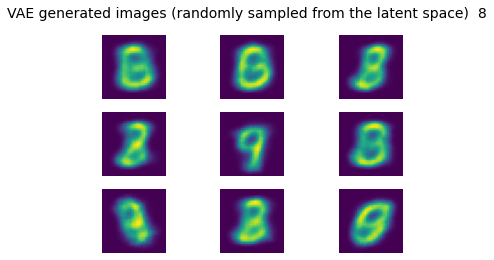

4375/4375 [==============================] - 36s 8ms/step - loss: 0.2547


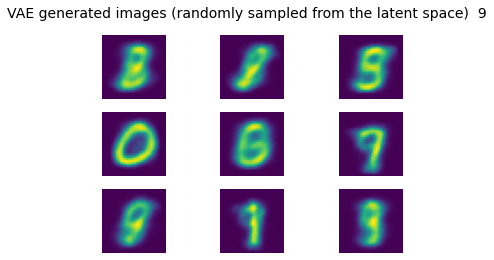

4375/4375 [==============================] - 36s 8ms/step - loss: 0.2546


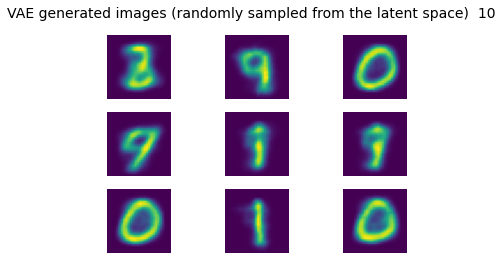

4375/4375 [==============================] - 35s 8ms/step - loss: 0.2543


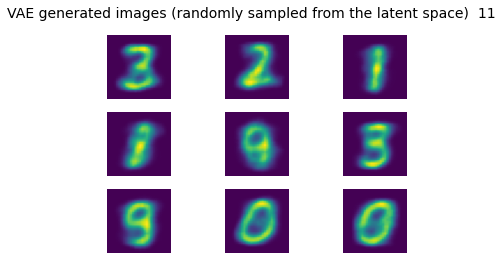

4375/4375 [==============================] - 36s 8ms/step - loss: 0.2544


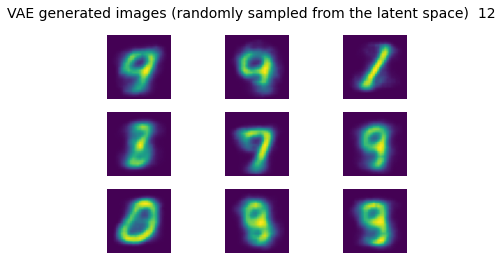

4375/4375 [==============================] - 36s 8ms/step - loss: 0.2543


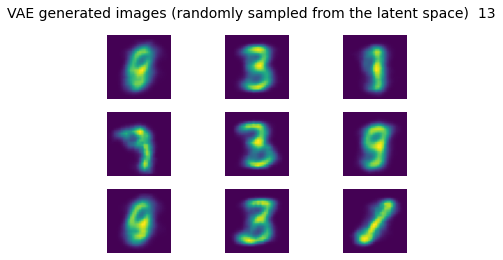

4375/4375 [==============================] - 35s 8ms/step - loss: 0.2542


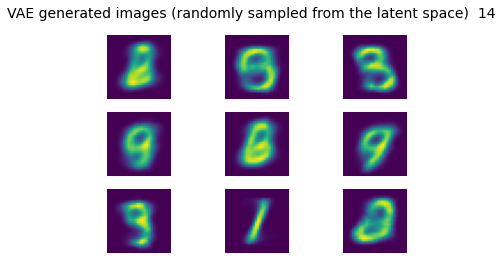

4375/4375 [==============================] - 36s 8ms/step - loss: 0.2542


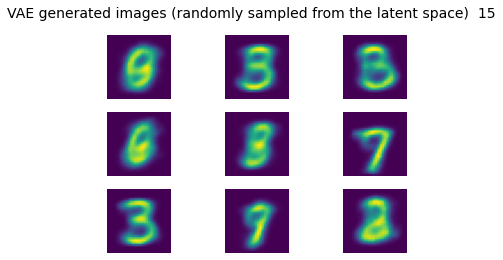

4375/4375 [==============================] - 35s 8ms/step - loss: 0.2539


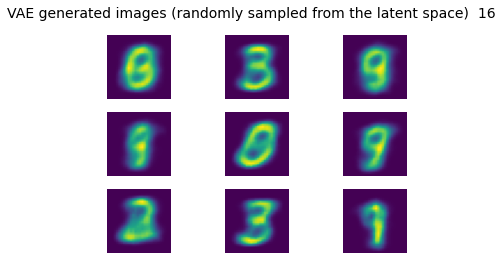

4375/4375 [==============================] - 36s 8ms/step - loss: 0.2539


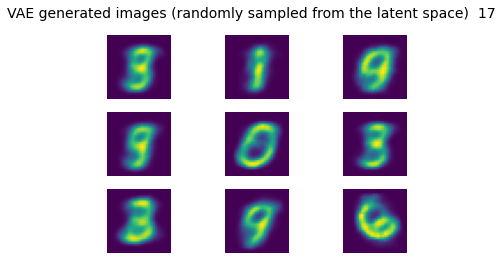

4375/4375 [==============================] - 36s 8ms/step - loss: 0.2538


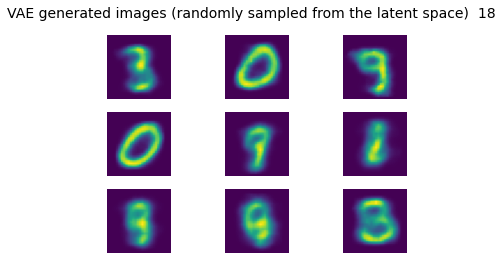

4375/4375 [==============================] - 35s 8ms/step - loss: 0.2538


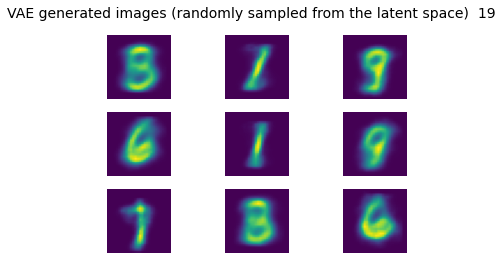

In [8]:
# Training the VAE model
latent_dim = 32
encoder, decoder, vae = build_vae(X.shape[1:], latent_dim)

# Generate random vectors that we will use to sample our latent space
for epoch in range(0, 20):
    vae.fit(x=X, y=X, epochs=1, batch_size=16, verbose=1)
    latent_vectors = np.random.randn(9, latent_dim)
    images = decoder(latent_vectors)
    grid_plot(images, epoch, name='VAE generated images (randomly sampled from the latent space)', n=3, save=False)

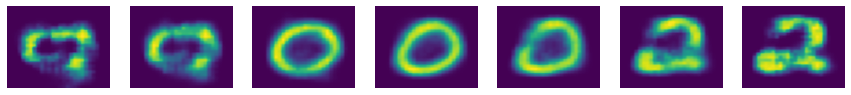

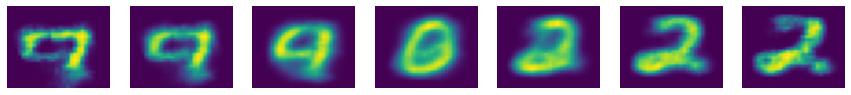

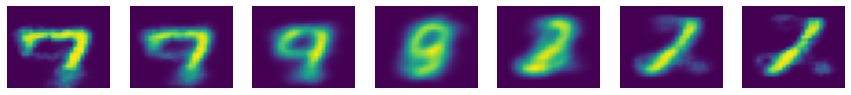

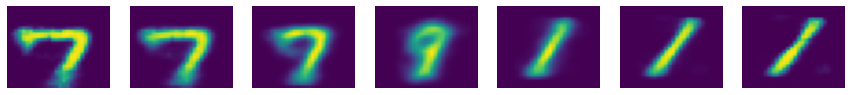

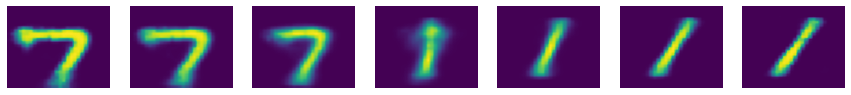

In [32]:
latent_dim = 32
for i in range(-2, 3):
    np.random.seed(42)
    latent_vectors = np.tile(np.random.randn(latent_dim), (7, 1))
    latent_vectors[:, 9] = np.linspace(-5, 5, num=7)
    latent_vectors[:, 26] = i * np.ones(7)

    images = decoder(latent_vectors)
    plt.figure(figsize = (15, 1.5))
    for index in range(7):
        plt.subplot(1, 7, index + 1)
        plt.axis('off')
        plt.imshow(images[index], aspect='auto')
    plt.show()

In [28]:
# Use build_gan, run_generator, get_batch, train_gan function in the tutorial
def build_gan(data_shape, latent_dim, lr=0.0002, beta_1=0.5):
    optimizer = tf.optimizers.Adam(learning_rate=lr, beta_1=beta_1)

    # Usually the GAN generator has tanh activation function in the output layer
    generator = build_deconv_net(latent_dim, activation_out='tanh')
    
    # Build and compile the discriminator
    discriminator = build_conv_net(in_shape=data_shape, out_shape=1) # Single output for binary classification
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # End-to-end GAN model for training the generator
    discriminator.trainable = False
    true_fake_prediction = discriminator(generator.output)
    GAN = tf.keras.Model(inputs=generator.input, outputs=true_fake_prediction)
    GAN = tf.keras.models.Sequential([generator, discriminator])
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return discriminator, generator, GAN


def run_generator(generator, n_samples=100):
    """
    Run the generator model and generate n samples of synthetic images using random latent vectors
    """
    latent_dim = generator.layers[0].input_shape[-1]
    generator_input = np.random.randn(n_samples, latent_dim[1])

    return generator.predict(generator_input)
    

def get_batch(generator, dataset, batch_size=64):
    """
    Gets a single batch of samples (X) and labels (y) for the training the discriminator.
    One half from the real dataset (labeled as 1s), the other created by the generator model (labeled as 0s).
    """
    batch_size //= 2 # Split evenly among fake and real samples

    fake_data = run_generator(generator, n_samples=batch_size)
    real_data = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

    X = np.concatenate([fake_data, real_data], axis=0)
    y = np.concatenate([np.zeros([batch_size, 1]), np.ones([batch_size, 1])], axis=0)

    return X, y


def train_gan(generator, discriminator, gan, dataset, latent_dim, n_epochs=20, batch_size=64):

    batches_per_epoch = int(dataset.shape[0] / batch_size / 2)
    for epoch in range(n_epochs):
        for batch in range(batches_per_epoch):
            
            # 1) Train discriminator both on real and synthesized images
            X, y = get_batch(generator, dataset, batch_size=batch_size)
            discriminator_loss = discriminator.train_on_batch(X, y)

            # 2) Train generator (note that now the label of synthetic images is reversed to 1)
            X_gan = np.random.randn(batch_size, latent_dim)
            y_gan = np.ones([batch_size, 1])
            generator_loss = gan.train_on_batch(X_gan, y_gan)
            
        noise = np.random.randn(16, latent_dim)
        images = generator.predict(noise)
        grid_plot(images, epoch, name='GAN generated images', n=3, save=False, scale=True)

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256)]             0         
                                                                 
 dense_16 (Dense)            (None, 12544)             3223808   
                                                                 
 reshape_7 (Reshape)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_35 (Conv2D)          (None, 28, 28, 1)         289       
                                                                 
Total params: 3,242,561
Trainable params: 3,242,561
Non-trainable params: 0
________________________________________________

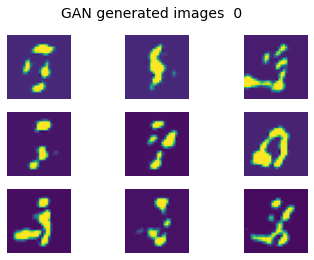

1/1 [==============================] - 0s 27ms/step


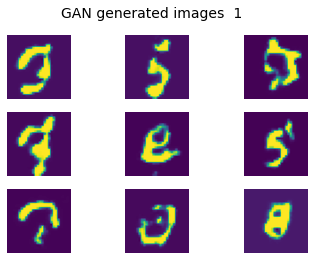

1/1 [==============================] - 0s 29ms/step


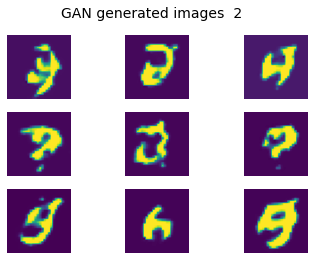

1/1 [==============================] - 0s 117ms/step


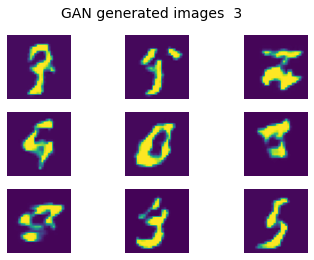

1/1 [==============================] - 0s 48ms/step


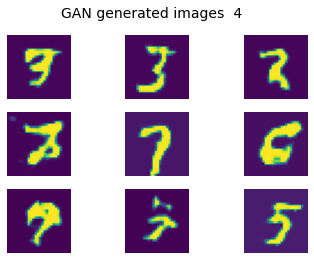

1/1 [==============================] - 0s 77ms/step


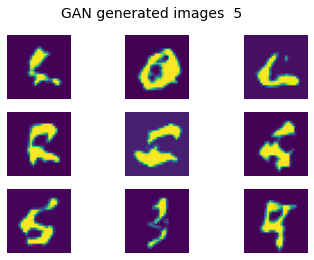

1/1 [==============================] - 0s 60ms/step


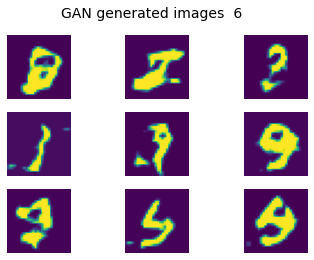

1/1 [==============================] - 0s 32ms/step


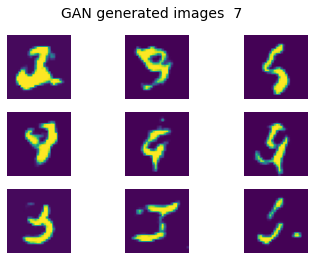

1/1 [==============================] - 0s 27ms/step


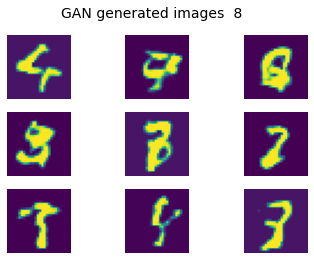

1/1 [==============================] - 0s 29ms/step


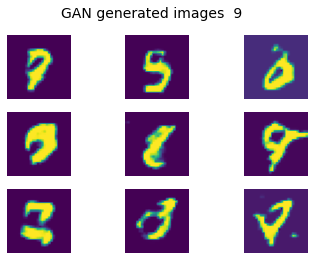

1/1 [==============================] - 0s 26ms/step


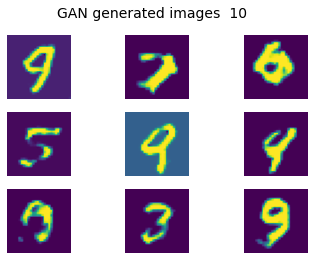

1/1 [==============================] - 0s 76ms/step


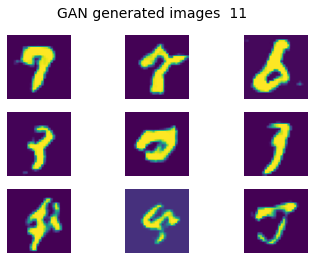

1/1 [==============================] - 0s 61ms/step


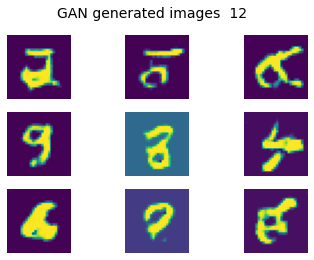

1/1 [==============================] - 0s 36ms/step


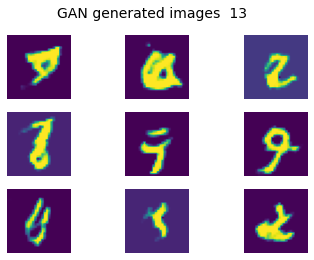

1/1 [==============================] - 0s 28ms/step


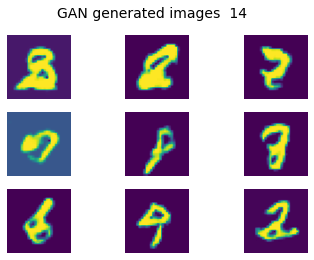

1/1 [==============================] - 0s 26ms/step


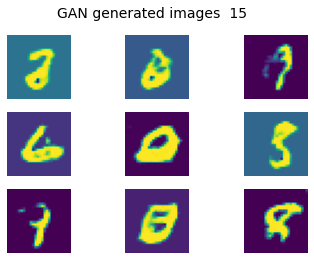

1/1 [==============================] - 0s 28ms/step


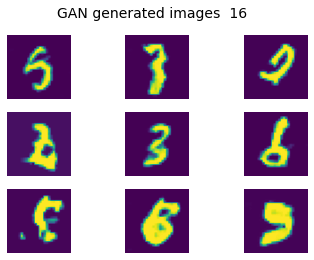

1/1 [==============================] - 0s 27ms/step


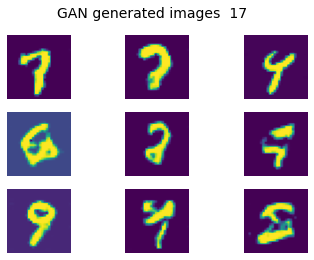

1/1 [==============================] - 0s 38ms/step


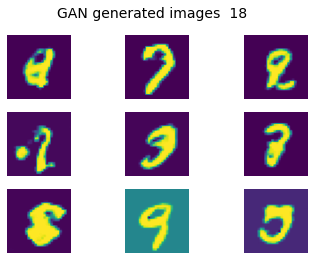

1/1 [==============================] - 0s 27ms/step


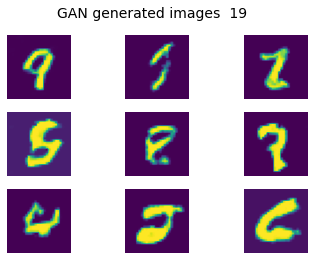

In [29]:
# Build and train the model (need around 10 epochs to start seeing some results)
latent_dim = 256
discriminator, generator, gan = build_gan(X.shape[1:], latent_dim)

train_gan(generator, discriminator, gan, X, latent_dim, n_epochs=20)

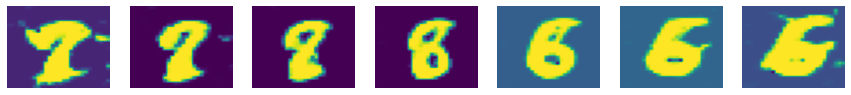

In [66]:
latent_dim = 256

np.random.seed(13)
latent_vectors = np.tile(np.random.randn(latent_dim), (7, 1))
latent_vectors[:, 0] = np.linspace(-30, 30, num=7)

images = generator(latent_vectors)
plt.figure(figsize = (15, 1.5))
for index in range(7):
    plt.subplot(1, 7, index + 1)
    plt.axis('off')
    plt.imshow(images[index], aspect='auto')
plt.show()

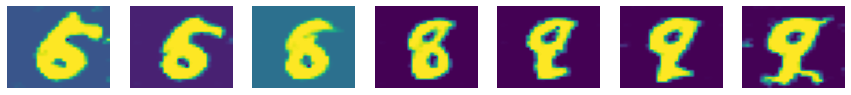

In [67]:
latent_dim = 256

np.random.seed(13)
latent_vectors = np.tile(np.random.randn(latent_dim), (7, 1))
latent_vectors[:, 119] = np.linspace(-30, 30, num=7)

images = generator(latent_vectors)
plt.figure(figsize = (15, 1.5))
for index in range(7):
    plt.subplot(1, 7, index + 1)
    plt.axis('off')
    plt.imshow(images[index], aspect='auto')
plt.show()

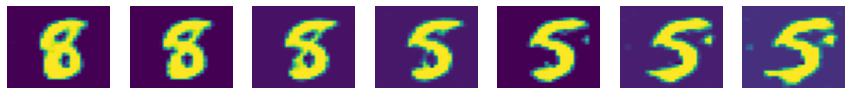

In [69]:
latent_dim = 256

np.random.seed(13)
latent_vectors = np.tile(np.random.randn(latent_dim), (7, 1))
latent_vectors[:, 125] = np.linspace(0, 30, num=7)

images = generator(latent_vectors)
plt.figure(figsize = (15, 1.5))
for index in range(7):
    plt.subplot(1, 7, index + 1)
    plt.axis('off')
    plt.imshow(images[index], aspect='auto')
plt.show()